# Projet MGL869 - Prédiction d'obésité

## Jeu de données

### Contexte

**Jeu de données : Estimation des niveaux d'obésité en fonction des habitudes alimentaires et de la condition physique**

Ce jeu de données comprend des données pour l'estimation des niveaux d'obésité chez des individus des pays du Mexique, du Pérou et de la Colombie, en se basant sur leurs habitudes alimentaires et leur condition physique.

Les données contiennent 17 attributs et 2111 enregistrements, ces enregistrements sont étiquetés avec la variable de classe NObesity (Niveau d'obésité), ce qui permet de classifier les données en utilisant les valeurs suivantes : Insuffisance pondérale, Poids normal, Surpoids Niveau I, Surpoids Niveau II, Obésité Type I, Obésité Type II et Obésité Type III. 77% des données ont été générées synthétiquement à l'aide de l'outil Weka et du filtre SMOTE, 23% des données ont été collectées directement auprès des utilisateurs via une plateforme web.

[Jeu de donnée disponible à cet addresse](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition) (2019)

### 1 - Importation des données

In [169]:
import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, I/O de fichier CSV (par ex. pd.read_csv)
import seaborn as sns # bibliothèque de tracé qui utilise matplot
import matplotlib.pyplot as plt # pour tracer certains paramètres dans seaborn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

df = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### 2 - Adaptation des types de données

On transforme les données pour que les types correspondent à ceux données sur le site ou est proposé le dataset.

In [170]:
df2 = df.copy();
# Object to category
df2[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]] = df2[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]].astype("category")

# Object to binary
df2["family_history_with_overweight"] = df["family_history_with_overweight"].map({"yes": True, "no": False})
df2["FAVC"] = df["FAVC"].map({"yes": True, "no": False})
df2["SMOKE"] = df["SMOKE"].map({"yes": True, "no": False})
df2["SCC"] = df["SCC"].map({"yes": True, "no": False})

# Float to int
df2[["FCVC", "TUE"]] = df2[["FCVC", "TUE"]].astype("int")


df2.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,True,False,2,3.0,Sometimes,False,2.0,False,0.0,1,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,True,False,3,3.0,Sometimes,True,3.0,True,3.0,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,True,False,2,3.0,Sometimes,False,2.0,False,2.0,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,False,False,3,3.0,Sometimes,False,2.0,False,2.0,0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,False,False,2,1.0,Sometimes,False,2.0,False,0.0,0,Sometimes,Public_Transportation,Overweight_Level_II


### 3 - Intuitions vis à vis du jeu de données

In [171]:
df3 = df2.copy()

L'on remarque la présence des données "height" and "weight" dans notre dataset. En examinant l'article associé, l'on remarque que le niveau d'obésité est dérivé de l'IMC, un calcul ayant pour paramètre la taille et le poids. Si nous conservons ces données dans notre modèle, alors celui-ci ne présente plus d'intéret, car un simple calcul serait plus fiable.

Ainsi, une direction plus appropriée pour notre modèle serait de détermiiner si une personne est sujet à l'obésité à l'aide de caractéristiques autres que la taille et le poids, plus en rapport au mode de vie. Nous supprimons donc ces colonnes.

In [172]:
df3 = df3.drop(columns=["Height", "Weight"])

De plus, un certains nombre de propriétés sont déclarer comme des flotants. Or, quand on regarde les questions posées dans le papier pour l'obtention des informations, les réponses sont données sous forme de catégories avec une relation ordinal. Ce qui fait qu'avoir des nombres à virgules ne fait pas beacoup de sens dans certains cas.

Par exmple, la donnée CH2O représente la quantité d'eau bu par jour :
- 0 : Moins de 1L
- 1 : Entre 1 et 2L
- 2 : Plus de 2L

Dans ce contexte, une valeur de 0.5 ne fait pas de sens.

Pour remédier à ce problème, nous convertissons les données sujet à ce soucis en int.

In [173]:
columns = ["NCP", "CH2O", "FAF"]

for col in columns:
    #round to nearest whole number
    df3[col] = round(df3[col]).astype('int')

df3.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,True,False,2,3,Sometimes,False,2,False,0,1,no,Public_Transportation,Normal_Weight
1,Female,21.0,True,False,3,3,Sometimes,True,3,True,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,True,False,2,3,Sometimes,False,2,False,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,False,False,3,3,Sometimes,False,2,False,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,False,False,2,1,Sometimes,False,2,False,0,0,Sometimes,Public_Transportation,Overweight_Level_II


### 4 - Analyse des données


#### Infos et description

In [174]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   category
 1   Age                             2111 non-null   float64 
 2   family_history_with_overweight  2111 non-null   bool    
 3   FAVC                            2111 non-null   bool    
 4   FCVC                            2111 non-null   int32   
 5   NCP                             2111 non-null   int32   
 6   CAEC                            2111 non-null   category
 7   SMOKE                           2111 non-null   bool    
 8   CH2O                            2111 non-null   int32   
 9   SCC                             2111 non-null   bool    
 10  FAF                             2111 non-null   int32   
 11  TUE                             2111 non-null   int32   
 12  CALC                

On remarque qu'il n'y a pas de valeur NaN. Nous n'avons donc pas d'étape de supression des NaNs à effectuer.

In [175]:
df3.describe()

,Age,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,2.213169,2.687826,2.014685,1.006632,0.381336
std,6.345968,0.599397,0.809680,0.688616,0.895462,0.582536
min,14.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,2.000000,3.000000,2.000000,0.000000,0.000000
50%,22.777890,2.000000,3.000000,2.000000,1.000000,0.000000
75%,26.000000,3.000000,3.000000,2.000000,2.000000,1.000000
max,61.000000,3.000000,4.000000,3.000000,3.000000,2.000000


On remarque que la portée des données diffères beacoup entre l'âge et les valeurs ordinals. Nous aurons donc besoin d'une normalisation ou d'une standardisation.

In [176]:
df3.describe(include=["category"])

,Gender,CAEC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111
unique,2,4,4,5,7
top,Male,Sometimes,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1765,1401,1580,351


La présence de données catégoriels nous indique la nécéssité de mettre en place du one hot encoding pour ces valeurs.

#### Donnée numérique floatants

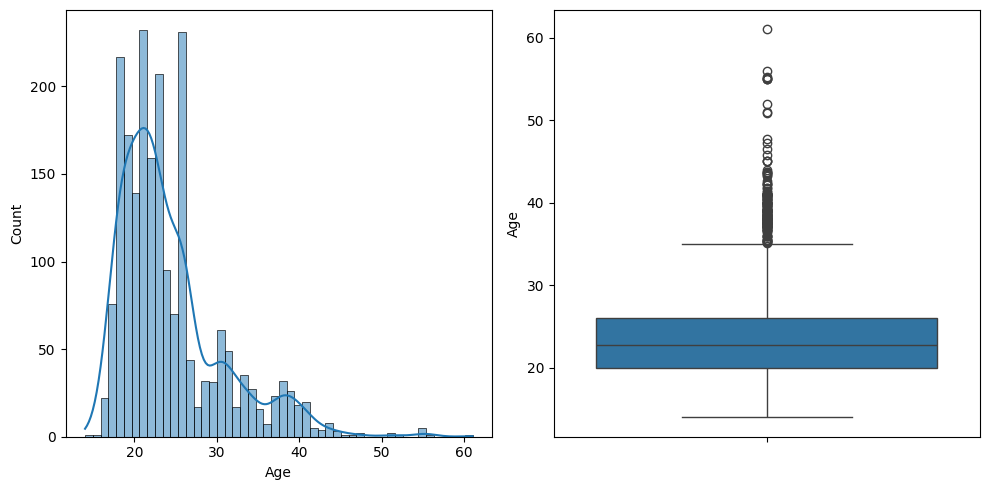

In [177]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes = axes.flatten()

sns.histplot(df3["Age"], kde=True, ax=axes[0])
sns.boxplot(df3["Age"], ax=axes[1])
plt.tight_layout()
plt.show()

- **Age**
  - Type de valeur : Numérique continue
  - Distribution : Non normal
  - Problèmes : Données non normalisée
    - *Solution 1* : Appliquer Log10() pour normaliser la distribution
      - Ne marche pas dans ce cas (voir exemple)
    - *Solution 2* : Transformer la valeur en valeur categoriel
    - *Solution 3* : Garder les données tel quelles
  - Box plot : Indication de outliers
    - Cependant, données vérifiées car il s'agit d'un âge

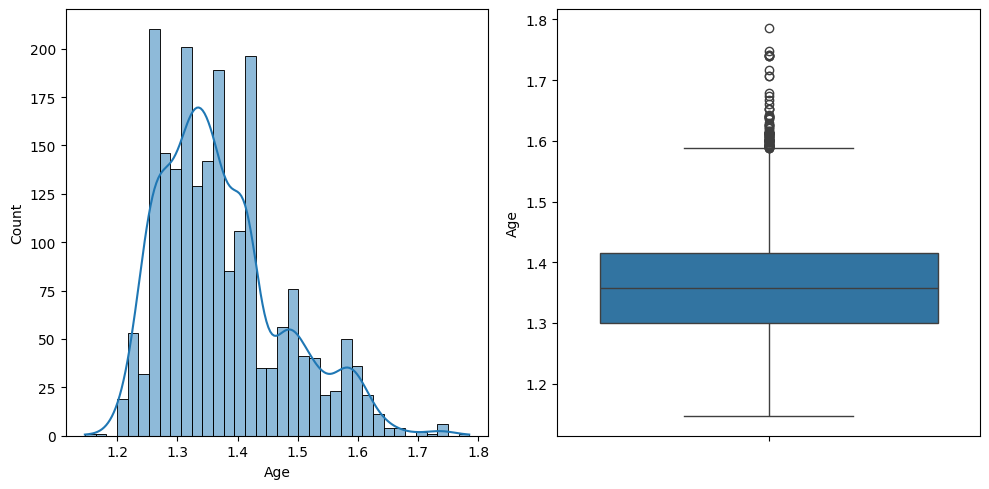

In [178]:
log_example = np.log10(df3["Age"])

fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes = axes.flatten()

sns.histplot(log_example, kde=True, ax=axes[0])
sns.boxplot(log_example, ax=axes[1])
plt.tight_layout()
plt.show()

#### Donnée numériques int

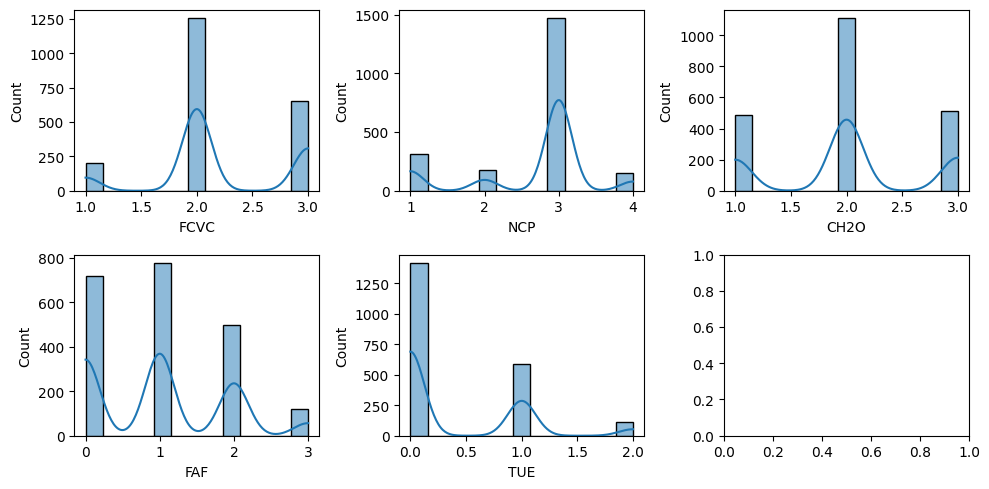

In [179]:
fig, axes = plt.subplots(2,3, figsize=(10, 5))
axes = axes.flatten()

for ax, col in zip(axes, ["FCVC", "NCP", "CH2O", "FAF", "TUE"]) :
    sns.histplot(df3[col], kde=True, ax=ax)

plt.tight_layout()
plt.show()

**Données**

- FCVC (Légumes dans les repas)
- NCP (Nombre de repas par jour)
- CH2O (Quantité d'eau bu par jour)
- FAF (Fréquence activité physique)
- TUE (Temps passé sur les écrans)

**Problèmes**  
Données non équilibrés

**Solutions**  
Downsampling et Upweighting. Il s'agit de deux techniques de construction de set de données permetant de mitiger les problèmes de données non équilibrés. Cependant, le déséquilibre n'etant pas extrème, nous n'implementerons pas cette solution.

**Remarques**  
De part leur nature, l'on pourrait penser les convertir en catégorie. Cependant, ces variables présentent des relations ordinales qu'il convient de conserver pour améliorer la justesse du modèle.

#### Données catégoriels et booléenes

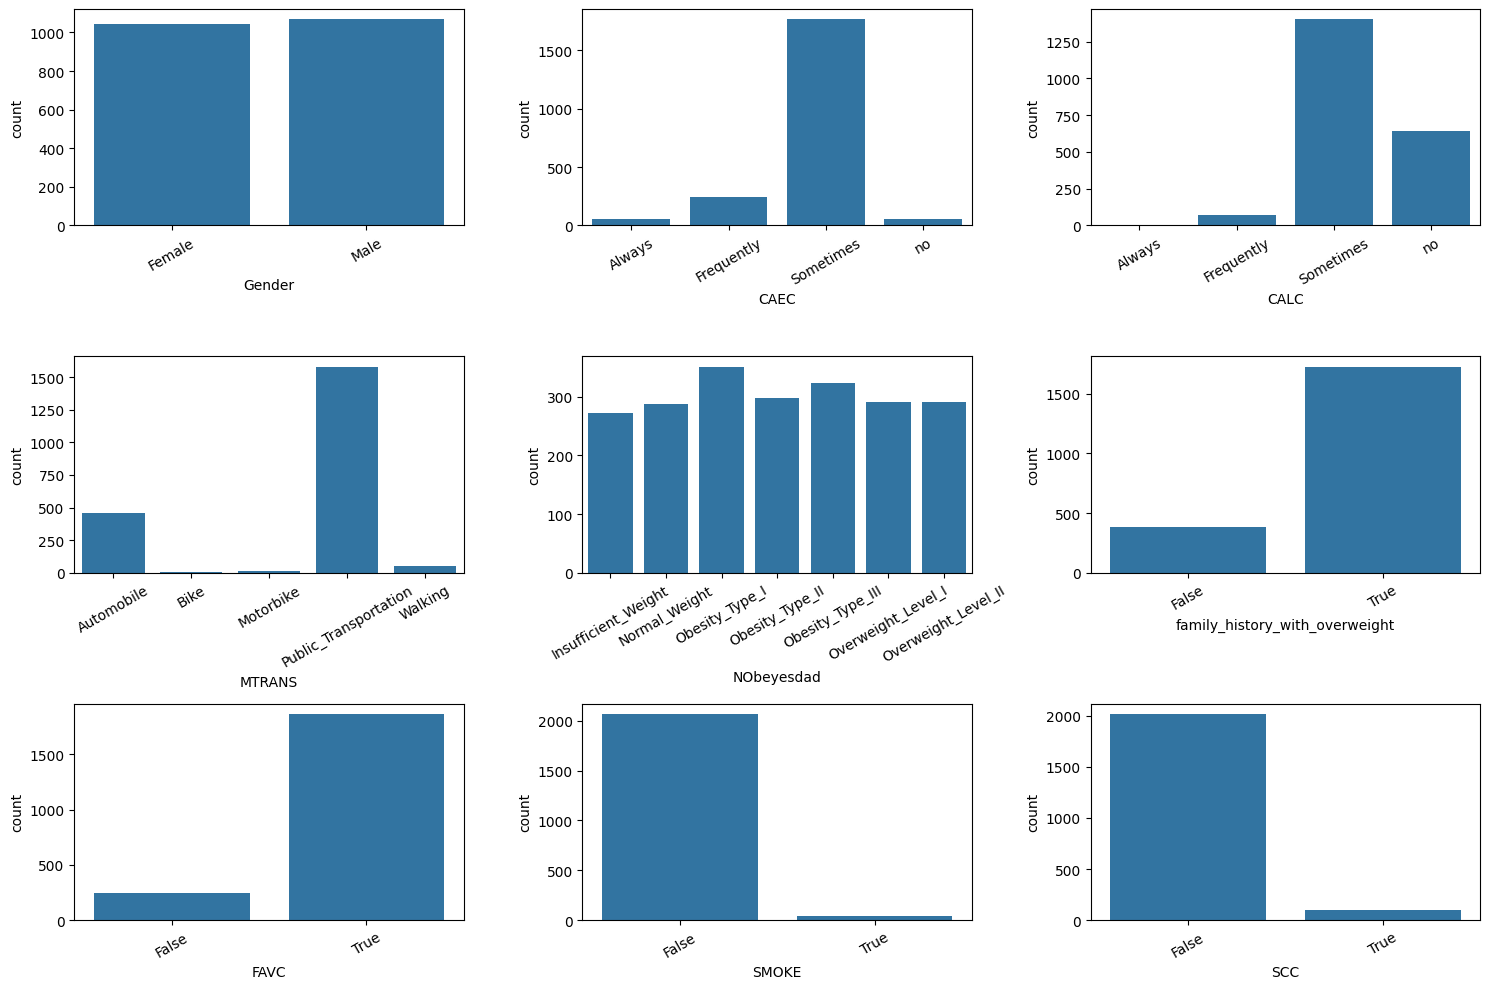

In [180]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, ["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]) :
    sns.countplot(x=df3[col], ax=ax)
    ax.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

**Données**

- Gender
- CAEC (Nourriture entre les repas)
- CALC (Fréquence alcool)
- MTRANS (Moyen de transport)
- Nobeyesdad (Catégorie d'obésité) (variable cible)
- family_history_with_overweight
- FAVC (Consomation fréquente de nourriture à haute calories)
- SMOKE
- SCC (Surveillance des calories)

**Problèmes**  
1. Données non équilibrés

**Solutions**  
1. Downsampling et Upweighting. Il s'agit de deux techniques de construction de set de données permetant de mitiger les problèmes de données non équilibrés. Cependant, le déséquilibre n'etant pas extrème, nous n'implementerons pas cette solution.

**Remarques**  
Certaines de ces catégories (CAEC, CALC, Nobeyesdad) ont des relation que l'on pourrait considérer ordinal. Conserver cette relation pourrait être intéréssant, nous pouvons donc appliquer un encoder oridinal sur ces valeurs.

#### Matrice de corrélation

In [181]:
corr_matrix = df3.select_dtypes(exclude=['category']).corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,Age,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE
Age,1.00,0.21,0.06,-0.02,-0.04,0.09,-0.02,-0.12,-0.13,-0.24
family_history_with_overweight,0.21,1.00,0.21,0.01,0.06,0.02,0.14,-0.19,-0.05,-0.10
FAVC,0.06,0.21,1.00,-0.07,-0.01,-0.05,0.01,-0.19,-0.10,-0.05
FCVC,-0.02,0.01,-0.07,1.00,0.07,0.03,0.12,0.07,-0.02,-0.15
NCP,-0.04,0.06,-0.01,0.07,1.00,0.01,0.06,-0.01,0.13,-0.00
SMOKE,0.09,0.02,-0.05,0.03,0.01,1.00,-0.04,0.05,0.01,0.06
CH2O,-0.02,0.14,0.01,0.12,0.06,-0.04,1.00,-0.00,0.12,-0.04
SCC,-0.12,-0.19,-0.19,0.07,-0.01,0.05,-0.00,1.00,0.07,0.03
FAF,-0.13,-0.05,-0.10,-0.02,0.13,0.01,0.12,0.07,1.00,0.08
TUE,-0.24,-0.10,-0.05,-0.15,-0.00,0.06,-0.04,0.03,0.08,1.00


L'on conclut qu'aucune valeurs ne sont manifestement corrélées entre elles.


### 5 - Pipeline

Avec notre analyse, nous pouvons imaginer la pipelines suivantes:
- Suppresion des colonnes "Height" et "Weight"
- Transformation des colonnes restantes aux types spécifiées
- Conversions des données flotantes en int (sauf pour âge)
  - Optionnel -> Convertir Age en catégorie
- Appliquer le Ordinal Encoding sur CAEC, CALC et Nobeyesdad
- Appliquer le OneHot Encoding sur Gender, MTRANS, familiy_history_with_overweight, FAVC
- Normaliser l'ensemble des données

In [182]:
def prepareData(df):
    # Drop columns
    prepared_df = df.drop(columns=["Height", "Weight"])

    # Objects to category
    prepared_df[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]] = prepared_df[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]].astype("category")
    
    # Object to binary
    prepared_df["family_history_with_overweight"] = prepared_df["family_history_with_overweight"].map({"yes": True, "no": False})
    prepared_df["FAVC"] = prepared_df["FAVC"].map({"yes": True, "no": False})
    prepared_df["SMOKE"] = prepared_df["SMOKE"].map({"yes": True, "no": False})
    prepared_df["SCC"] = prepared_df["SCC"].map({"yes": True, "no": False})

    # Float to int
    prepared_df[["FCVC", "TUE"]] = prepared_df[["FCVC", "TUE"]].astype("int")

    # Transform senseless floats into ints
    for col in ["NCP", "CH2O", "FAF"]:
        #round to nearest whole number
        prepared_df[col] = round(prepared_df[col]).astype('int')

    # Ordinal encoding
    ord_enc = OrdinalEncoder()
    prepared_df[["CAEC", "CALC", "NObeyesdad"]] = ord_enc.fit_transform(prepared_df[["CAEC", "CALC", "NObeyesdad"]])

    # One Hot encoding
    prepared_df = pd.get_dummies(prepared_df, columns=["Gender", "MTRANS", "family_history_with_overweight", "FAVC"])
    prepared_df.replace({False: 0, True: 1}, inplace=True)
    
    return prepared_df

df_final = prepareData(df)
df_final.head()



C:\Users\felix\AppData\Local\Temp\ipykernel_43320\4090555811.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prepared_df.replace({False: 0, True: 1}, inplace=True)


,Age,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,...,Gender_Male,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,family_history_with_overweight_False,family_history_with_overweight_True,FAVC_False,FAVC_True
0,21.0,2,3,2.0,0,2,0,0,1,3.0,...,0,0,0,0,1,0,0,1,1,0
1,21.0,3,3,2.0,1,3,1,3,0,2.0,...,0,0,0,0,1,0,0,1,1,0
2,23.0,2,3,2.0,0,2,0,2,1,1.0,...,1,0,0,0,1,0,0,1,1,0
3,27.0,3,3,2.0,0,2,0,2,0,1.0,...,1,0,0,0,0,1,1,0,1,0
4,22.0,2,1,2.0,0,2,0,0,0,2.0,...,1,0,0,0,1,0,1,0,1,0


The mika way uwu

In [183]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import Normalizer

df = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv", dtype={
  'Gender':'category',
  'CAEC':'category',
  'CALC':'category',
  'MTRANS':'category',
  'NObeyesdad':'category'
})

Y = df['NObeyesdad']
X = df.drop(['NObeyesdad', 'Weight', 'Height'], axis=1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42) # il doit y avoir mieux

numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        # ('normalizer', Normalizer()) # moins bien
        ("scaler", StandardScaler()) # essayer un normaliser ?
    ]
)

categorical_features = X.select_dtypes(include=["category"]).columns
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        # ("selector", SelectPercentile(chi2, percentile=50)), # a check, semble pas bien
    ]
)

# on emboite juste les 2 d'avants
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorial", categorical_transformer, categorical_features),
    ]
)


### 6 - Mise en oeuvre du modèle RandomForestClassifier

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier


# model = VotingClassifier(estimators=[ 
#     ('svm', SVC(probability=True)),
#     ('lr', LogisticRegression()),
#     ('gboost', GradientBoostingClassifier()),
# ], voting='soft')

# On rajoute le model
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("rforest", RandomForestClassifier())
        # ("voting", model)
    ]
)

param_grid = {
    'rforest__n_estimators': [400, 500, 600],
    'rforest__max_depth': [10, 15, 20],
    'rforest__min_samples_split': [2, 5, 8],
    'rforest__bootstrap': [True, False],
}

# param_grid = { # a tester plus large car par au delas des limites peuvent etre mieux
# 'voting__gboost__n_estimators': 30, 'voting__lr__C': 1.0, 'voting__svm__C': 4
#     'voting__lr__C': [1.0, 100.0, 200.0],
#     'voting__svm__C': [2,3,4],
#     'voting__gboost__n_estimators': [10,20,30]
# }

test de performance du modèle RandomForestClassifier

In [185]:
# 48s
# il faut test randomizersearchCV + changer les params
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_micro') 
grid_search.fit(X_train, Y_train)

Y_pred = grid_search.predict(X_val)
accuracy = accuracy_score(Y_val, Y_pred)
print(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_} \nAccuracy: {accuracy}')

Params: {'rforest__bootstrap': False, 'rforest__max_depth': 20, 'rforest__min_samples_split': 5, 'rforest__n_estimators': 500} 
Score: 0.8157599202712128 
Accuracy: 0.817966903073286


In [186]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('categorial',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'CAEC', 'CALC', 'MTRANS'], dtype='object'))])),
                ('rforest',
                 RandomForestClassifier(bootstrap=False, max_depth=20,
                                        min_samples_split=5,
                                        n_estimators=500))])

### Modèle : DecisionTreeClassifier

In [187]:
from sklearn.tree import DecisionTreeClassifier
# dt_clf = DecisionTreeClassifier(random_state=1)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("rTree", DecisionTreeClassifier())
        # ("voting", model)
    ]
)


Entraîner le modèle DecisionTreeClassifier sur les données d'entraînement


In [189]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('categorial',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'CAEC', 'CALC', 'MTRANS'], dtype='object'))])),
                ('rTree', DecisionTreeClassifier())])

Résultat de Cross-validation sur l'arbre de décision

In [190]:
from sklearn.model_selection import cross_val_score
cv_dt = cross_val_score(pipeline, X_train, Y_train, cv=10)

print(cv_dt)
print(cv_dt.mean())

[0.65680473 0.78106509 0.79881657 0.76331361 0.68047337 0.75739645
 0.73964497 0.68047337 0.71428571 0.80357143]
0.7375845308537616


Évaluer le modèle DecisionTreeClassifier sur les données de validation

In [191]:
from sklearn.metrics import recall_score, f1_score
pipeline.fit(X_train, Y_train)
y_pred_val = pipeline.predict(X_val)

acc_val = accuracy_score(Y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val:.2f}")

# Calculer le rappel
recall_val = recall_score(Y_val, y_pred_val, average='macro')
print(f"Rappel sur les données de validation : {recall_val:.2f}")

# Calculer le F1 score
f1_val = f1_score(Y_val, y_pred_val, average='macro')
print(f"F1 score sur les données de validation : {f1_val:.2f}")

Accuracy sur les données de validation : 0.72
Rappel sur les données de validation : 0.72
F1 score sur les données de validation : 0.72


Test d'optimisation des hyperparamètres avec GridSearch

In [198]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

param_grid = {
    "rTree__criterion": ["gini", "entropy", 'log_loss'],
    "rTree__max_depth": [None, 10, 20, 30],
    "rTree__min_samples_split": [2, 5, 10],
    "rTree__min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_micro') 
grid_search.fit(X_train, Y_train)

# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de validation
Y_pred = grid_search.predict(X_val)
accuracy = accuracy_score(Y_val, Y_pred)
print(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_} \nAccuracy: {accuracy}')

Params: {'rTree__criterion': 'gini', 'rTree__max_depth': None, 'rTree__min_samples_leaf': 1, 'rTree__min_samples_split': 2} 
Score: 0.7221681426184502 
Accuracy: 0.7210401891252955


Test d'optimisation des hyperparametres avec la recherche aléatoire

In [204]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Définir le dictionnaire de grille
param_distribs = {
    "rTree__criterion": ["gini", "entropy"],
    "rTree__max_depth": sp_randint(10, 100),
    "rTree__min_samples_split": sp_randint(2, 20),
    "rTree__min_samples_leaf": sp_randint(1, 10)
}

# Effectuer la recherche aléatoire
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distribs,
    scoring="f1_micro",
    cv=10,
    n_iter=100,
    n_jobs=-1,
    verbose=1
)

# Entraîner le pipeline sur les données d'entraînement
random_search.fit(X_train, Y_train)

Y_pred = random_search.predict(X_val)
accuracy = accuracy_score(Y_val, Y_pred)
print(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_} \nAccuracy: {accuracy}')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Params: {'rTree__criterion': 'gini', 'rTree__max_depth': None, 'rTree__min_samples_leaf': 1, 'rTree__min_samples_split': 2} 
Score: 0.7221681426184502 
Accuracy: 0.7304964539007093


### Modèle : SVC Linéaire

In [205]:
from sklearn.svm import LinearSVC


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("svcl", LinearSVC())
        # ("voting", model)
    ]
)

# Entraîner le modèle LinearSVC sur les données d'entraînement
pipeline.fit(X_train, Y_train)

# Évaluer le modèle LinearSVC sur les données de validation
y_pred_val = pipeline.predict(X_val)
acc_val = accuracy_score(Y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val:.2f}")


Accuracy sur les données de validation : 0.57


Test d'optimisation des hyperparamètres

In [209]:
param_grid = {
    "svcl__C": [0.01, 0.1, 1, 10, 100],
    "svcl__penalty": ["l1", "l2"],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_micro') 
grid_search.fit(X_train, Y_train)

# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de validation
Y_pred = grid_search.predict(X_val)
accuracy = accuracy_score(Y_val, Y_pred)
print(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_} \nAccuracy: {accuracy}')

Params: {'svcl__C': 100, 'svcl__penalty': 'l2'} 
Score: 0.5462106702569905 
Accuracy: 0.5721040189125296


On ne test pas la recherche aléatoire sur ce modèle puisque de toute façons les résultats sont beaucoup moins bon que pour les 2 précédents